# Lid-driven Cavity Flow using the Projection Method

## Introduction 

Consider the 2D incompressible Navier-Stokes equations (also known as momentum equations)

\begin{align}
& \frac{\partial u}{\partial t}+u \cdot \frac{\partial u}{\partial x}+v \cdot \frac{\partial u}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial x}+\nu \frac{\partial^2 u}{\partial x^2}+\nu \frac{\partial^2 u}{\partial y^2}, \\
& \frac{\partial v}{\partial t}+u \cdot \frac{\partial v}{\partial x}+v \cdot \frac{\partial v}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial y}+\nu \frac{\partial^2 v}{\partial x^2}+\nu \frac{\partial^2 v}{\partial y^2},
\end{align}

and the continuity equation

\begin{equation}
\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}=0,
\end{equation}

where $\mathbf{u} = (u,v)$ are flow velocities  in $x,y$ direction, $\rho$ is the density (constant for incompressible flow), $\nu$ is the kinematic viscosity, and $p$ stands for pressure.
One can write them into a more compact form (dimension free) as 

\begin{align}
\frac{\partial \mathbf{u}}{\partial t}+(\mathbf{u} \cdot \nabla) \mathbf{u}&= -\frac{1}{\rho} \nabla p+\nu \nabla^2 \mathbf{u}, \\
\nabla \cdot \mathbf{u} & =0.
\end{align}

---

### Staggered Grid

To deal with the checkerboard pressure problem, we assign different mesh systems to each primitive  variables $u,v,p$ as following.


<p align="center">
  <a href="https://www.cfd-online.com/Wiki/Staggered_grid">
    <img width=50% src="./Gallery/staggered_grid.png">
  </a>
</p>

The pressure is stored at the cell center and the velocities are stored at the cell faces.

---

### Chorin's Projection Method

The algorithm adopts an operator splitting approach in which one considers the viscous forces (in the first half step) and the pressure forces (in the second half step) separately. A distinguishing feature of Chorin's projection method is that the velocity field is forced to satisfy a discrete continuity constraint at the end of each time step.

We first discretize the time domain using an explicit Euler scheme

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}=-\frac{1}{\rho} \nabla p^{n+1}-\left(\mathbf{u}^n \cdot \nabla\right) +\nu \nabla^2 \mathbf{u}^n,
\end{equation}

where the time-step $\Delta t$ should be chosen so that $u \Delta t / \Delta x<1$ to satisfy the Courant-Friedrichs-Lewy (CFL) condition.

**Step I: Predictor step** \
Computes an intermediate velocity ${\mathbf  {u}}^{*}$, explicitly using the momentum equation by ignoring the pressure gradient term $\nabla p^{n+1} = 0$:

\begin{align}
\frac{\mathbf{u}^*-\mathbf{u}^n}{\Delta t} = -\left(\mathbf{u}^n \cdot \nabla\right) \mathbf{u}^n+\nu \nabla^2 \mathbf{u}^n, 
\end{align}

where $\mathbf{u}^n$ is the velocity at $n^{\text {th }}$ time step. 

**Step II: Projection step** \
We correct the intermediate velocity to obtain the final solution of the time step $\mathbf{u}^{n+1}$ 

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^*}{\Delta t}=-\frac{1}{\rho} \nabla p^{n+1}.
\end{equation}

**Step III: Pressure Poisson equation** \
Considering the divergence (continuity) condition at the next time step $t=n+1$, we have

\begin{align}
\nabla \cdot \mathbf{u}^{n+1} = 0
\quad \Rightarrow \quad
\nabla \cdot \bigg(\mathbf{u}^*-\frac{\Delta t}{\rho} \nabla p^{n+1} \bigg) = 0.
\end{align}

Reorganize it to obtain a Poisson problem

\begin{align}
\boxed{\nabla^2 p^{n+1}=\frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*.}
\end{align}

**Step IV: Velocity correction** \
Once we solve the Poisson problem, we can correct the velocity from ${\mathbf  {u}}^{*}$ to the next time step $\mathbf{u}^{n+1}$ 
\begin{align}
\mathbf{u}^{n+1}=\mathbf{u}^*-\frac{\Delta t}{\rho} \nabla p^{n+1}.
\end{align}

---

## Algorithm

The code below follows this guide https://www.montana.edu/mowkes/research/source-codes/GuideToCFD.pdf


In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import sparse
from qiskit.circuit.library import TwoLocal,RealAmplitudes,EfficientSU2,NLocal,PauliTwoDesign,QAOAAnsatz
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import CXGate, UGate
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit_aer.primitives import Estimator as Aer_Estimator
from qiskit_aer.primitives import Sampler as Aer_Sampler
from qiskit.primitives import Sampler as QSampler
from qiskit import Aer, transpile, QuantumCircuit
from qiskit_algorithms.optimizers import *
import time
import dill as pickle
import sys
import pentapy as pp
from quantum_utils import *
from qiskit_ibm_runtime import Session, QiskitRuntimeService, Options
from qiskit_ibm_runtime import Estimator as Estimator_Runtime
from qiskit_ibm_runtime import Sampler as Sampler_Runtime
from vqls_prototype.tomography import HTreeQST



solver = 'sparse'
res_tol = 1e-6
size = 2
Lx = 1              # length of domian in x-direction
Ly = 1              # length of domian in y-direction
n = size             # Half the number of qubits
nx = 2**n            # grid size in x-direction. Fixed to be in terms of number of qubits
ny = 2**n            # grid size in y-direction. Fixed to be in terms of number of qubits and square
quantum = True
hardware = True
q_method = "Global"
Re = 100          # Reynolds number
nu = 1/Re           # kinematic viscosity
rho = 1.0           # density
dt = 0.001          # time step size. 
itr = 30      # iterations

# Create staggered grid index system
imin, jmin = 1, 1
imax = imin + nx - 1
jmax = jmin + ny - 1

# Define ghost cells for boundary conditions
#x = np.zeros(jmax + 2)
x = sparse.lil_matrix((jmax+2,1))
#y = np.zeros(jmax + 2)
y = sparse.lil_matrix((jmax+2,1))
x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)

dx = (x[imin + 1] - x[imin]).data[0]
dy = (y[jmin + 1] - y[jmin]).data[0]
dxi = 1 / dx
dyi = 1 / dy

# Variable declaration
u = sparse.lil_matrix((imax + 2, jmax + 2))
v = sparse.lil_matrix((imax + 2, jmax + 2))

def boundary_condition(u, v):
    u[imin, jmin - 1:jmax + 1] = 0
    u[imax + 1, jmin - 1:jmax + 1] = 0
    u[imin: imax + 2, jmin - 1] = -u[imin: imax + 2, jmin]
    u[imin: imax + 2, jmax + 1] = 2*np.ones((jmax+1,imax + 1-imax)) - u[imin: imax + 2, jmax]


    v[imin - 1: imax + 2, jmin] = 0
    v[imin - 1: imax + 2, jmax + 1] = 0
    v[imin - 1, jmin:jmax + 1] = -v[imin, jmin:jmax + 1]
    v[imax + 1, jmin:jmax + 1] = -v[imax, jmin:jmax + 1]
if quantum:
    L = two_d_laplacian_paulis(n)
else:
    if solver in ['sparse', 'random']:
        L = form_two_d_poisson(nx,ny)
    else:
        L = Laplacian_d(nx,ny)
try:
    store_classical
except:
    store_classical = {}
try:
    store_quantum
except:
    store_quantum = {}
try:
    store_hardware 
except:
    store_hardware = {}
beg = time.time()
for iteration in range(itr):
    
    # u-momentum
    us = u.copy()
    u_lst = u.copy()
    I = slice(imin + 1, imax + 1)
    Ib = slice(imin, imax)
    If = slice(imin + 2, imax + 2)


    J = slice(jmin, jmax + 1)
    Jb = slice(jmin - 1, jmax)
    Jf = slice(jmin + 1, jmax + 2)


    v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
    us[I, J] = u[I, J] + dt * (
            nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
            + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
            - v_here.multiply(u[I, Jf] - u[I, Jb]) * 0.5 * dyi 
            - u[I, J].multiply(u[If, J] - u[Ib, J]) * 0.5 * dxi
    )


    # v-momentum
    vs = v.copy()
    v_lst = v.copy()
    I = slice(imin, imax + 1)
    Ib = slice(imin - 1, imax)
    If = slice(imin + 1, imax + 2)


    J = slice(jmin + 1, jmax + 1)
    Jb = slice(jmin, jmax)
    Jf = slice(jmin + 2, jmax + 2)


    u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
    vs[I, J] = v[I, J] + dt * (
            nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
            + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
            - u_here.multiply(v[If, J] - v[Ib, J]) * 0.5 * dxi
            - v[I, J].multiply(v[I, Jf] - v[I, Jb]) * 0.5 * dyi
    )

    # Claculate R.H.S of pressure Poisson
    Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                       - us[imin: imax + 1, jmin: jmax + 1]) * dx
                      + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                       - vs[imin: imax + 1, jmin: jmax + 1]) * dy)  
    R = Rn.T.reshape((1,nx*ny))
    R_sparse = sparse.lil_matrix(R).T
    if quantum:
        if  R.count_nonzero() == 0:
            pv = np.zeros(nx*ny)
            pn = pv.reshape(ny, nx).T
            q_solve = False
        else:
            b = R_sparse/sparse.linalg.norm(R_sparse)
            q_solve = True
        #def pressure_correct_quantum(imax, jmax, rhsp, Ap, p, alpha):
        if q_solve:
            outer_b = sparse.vstack(b) * sparse.vstack(b).T
            outer_b = SparsePauliOp.from_operator(Operator(outer_b.todense()))
            num_qubits = 2*n
            prep_circ = QuantumCircuit(num_qubits)
            for qubit in range(num_qubits):
                prep_circ.h(qubit)
            if q_method == "Global":
                H_test = L.compose((Ident(2*n)-outer_b)).compose(L)
                m_op = H_test.simplify()
            elif q_method == "Local":
                qc = QuantumCircuit(num_qubits)
                qc.initialize(b.toarray().T[0],normalize=True)
                U = Operator(transpile(qc,basis_gates=['u','cx'],optimization_level=3))
                sum_piece =  np.zeros((nx*ny,nx*ny))
                for q in range(num_qubits):
                    sum_piece += complement_eye(q)
                H_test2 = L.T.conj() @ U @ (np.eye(nx*ny) - 1/(num_qubits) * sum_piece) @ U.data.T.conj() @ L
                m_op = Operator(H_test2.real)
            else:
                raise ValueError("Quantum method not supported. Should be 'local' or 'global'")
            ansatz = RealAmplitudes(num_qubits,reps=num_qubits-1, initial_state=prep_circ)

            # Solve pressure correction implicitly and update pressure
            if not hardware:
                optimizer = L_BFGS_B(maxfun=90000, maxiter=50000, ftol=1e-18,max_evals_grouped=8)
                #optimizer = COBYLA(maxiter=1000,tol=1e-18,rhobeg=1)
                counts = []
                values = []
                std_vals = []
                def store_intermediate_result(eval_count, parameters, mean, std):
                    counts.append(eval_count)
                    values.append(mean)
                    std_vals.append(std)
                est = Aer_Estimator(run_options={"shots": None},approximation = True)
                if iteration < 2:
                    ip = np.random.rand(ansatz.num_parameters)
                else:
                    ip = result_sim.optimal_point
                
                vqe = VQE(est,ansatz,optimizer,initial_point=ip,callback=store_intermediate_result)
                result_sim = vqe.compute_minimum_eigenvalue(m_op)
                eig = result_sim.eigenvalue
                fixed_params = result_sim.optimal_point
                opt_circ = result_sim.optimal_circuit.assign_parameters(fixed_params)
                opt_state = Statevector(opt_circ)
            else:
                #Run simulation of VQE and keep the optimal parameters for use on hardware
                optimizer = L_BFGS_B(maxfun=90000, maxiter=50000, ftol=1e-18,max_evals_grouped=8)
                #optimizer = COBYLA(maxiter=1000,tol=1e-18,rhobeg=1)

                counts = []
                values = []
                std_vals = []
                def store_intermediate_result(eval_count, parameters, mean, std):
                    counts.append(eval_count)
                    values.append(mean)
                    #std_vals.append(std['variance'])
                est = Aer_Estimator(run_options={"shots": None},approximation = True)
                if iteration < 2:
                    ip = np.random.rand(ansatz.num_parameters)
                else:
                    ip = result_sim.optimal_point
                
                vqe = VQE(est,ansatz,optimizer,initial_point=ip,callback=store_intermediate_result)
                result_sim = vqe.compute_minimum_eigenvalue(m_op)
                eig = result_sim.eigenvalue
                fixed_params = result_sim.optimal_point
                
                #Hardware block
                service = QiskitRuntimeService(name='ornl')

                options = Options()
                shots = 8192
                options.execution.shots = shots
                options.optimization_level = 2  # Circuit level optimization
                options.resilience_level = 1 # SPAM mitigation
                options.transpilation.routing_method = 'sabre'
                options.transpilation.layout_method = 'noise_adaptive'
                device = service.get_backend('ibm_algiers')
                
                with Session(service=service, backend=device) as session:
                    #estimator_sim = Estimator_Runtime(session=session, options=options)
                    sampler_sim = Sampler_Runtime(session=session, options=options)
                    ht_samp = HTreeQST(ansatz,sampler_sim)
                    #job = estimator_sim.run(result_sim.optimal_circuit.assign_parameters(fixed_params),observables=m_op)
                    job_samp = ht_samp.get_statevector(fixed_params)
                
                #hardware_res = job.result().values[0]
                store_hardware.update({iteration:{'job':job_samp}})
                opt_circ = result_sim.optimal_circuit.assign_parameters(fixed_params)
                opt_state = Statevector(opt_circ)
                print("Hardware result",job_samp,'\n Simulator result:',opt_state.data.real)

            

            #opt_circ = transpile(opt_circ,basis_gates=['u','cx'],optimization_level=0)        
            #backend = Aer.get_backend('statevector_simulator')
            #vqes = backend.run(opt_circ)
            #res = vqes.result()
        
            def rescale_sol(A,p,b):
                rescale = A.to_matrix() @ p
                nzs2 = np.argmax(np.abs(b))
                scale_factor = b[nzs2]/rescale[nzs2]
                return scale_factor
            
            exact_h = NumPyMinimumEigensolver().compute_minimum_eigenvalue(SparsePauliOp.from_operator(m_op))
            
            pv = opt_state.data.real
            scale = rescale_sol(L,pv,b).data[0][0]
            pv = scale*pv*sparse.linalg.norm(R_sparse)
            
            pv_h = exact_h.eigenstate.data.real
            scale_h = rescale_sol(L,pv_h,b).data[0][0]
            pv_h = scale_h*pv_h*sparse.linalg.norm(R_sparse)
            
            if hardware:
                pv_hw = job_samp
                scale = rescale_sol(L,pv_hw,b).data[0][0]
                pv_hw = scale*pv_hw*sparse.linalg.norm(R_sparse)
                pn = pv_hw.reshape(ny, nx).T
                store_quantum.update({iteration:{'p' :pv,'result':result_sim,'p_h':pv_h,'p_hw':pv_hw,
                                                 'hw_error':np.max(L.to_matrix() @ pv_hw - R ).real}})
            else:
                store_quantum.update({iteration:{'p' :pv,'result':result_sim,'p_h':pv_h}})


            print("Iteration: ", iteration, " found eigenvalue:",result_sim.eigenvalue,
             "Sim Error:",np.max(L.to_matrix() @ pv - R ).real, "HW Error",np.max(L.to_matrix() @ pv_hw - R ).real)
            
    else:
        if solver =='sparse':
            pv = sparse.linalg.spsolve(L,R_sparse)
        elif solver =='dense':
            pv = np.linalg.solve(L_dense,R)
        elif solver =='pdiag':
            pv = pp.solve(L_dense,R)
        elif solver =='random':
            pv = sparse.lil_matrix((imax , jmax ))
        store_classical.update({iteration:(pv,R)})
    p = sparse.lil_matrix((imax + 1, jmax + 1))
    p[1:, 1:] = pn
    # Correct velocity
    u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
                p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
    v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
                p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi
    
    boundary_condition(u, v)

In [ ]:
pickle.dump(store_quantum,open('Hardware_Algiers_30.p','wb'))

In [126]:
hw_error = [0.015597487824820587,0.02496890538341343,0.024994490899752888,0.02202701258272808]

Text(0, 0.5, 'Error')

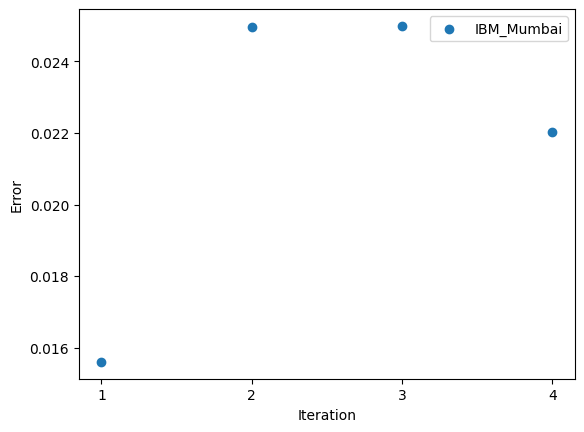

In [129]:
plt.scatter(range(1,5),hw_error,label='IBM_Mumbai')
plt.legend()
plt.xticks(range(1,5))
plt.xlabel('Iteration')
plt.ylabel('Error')

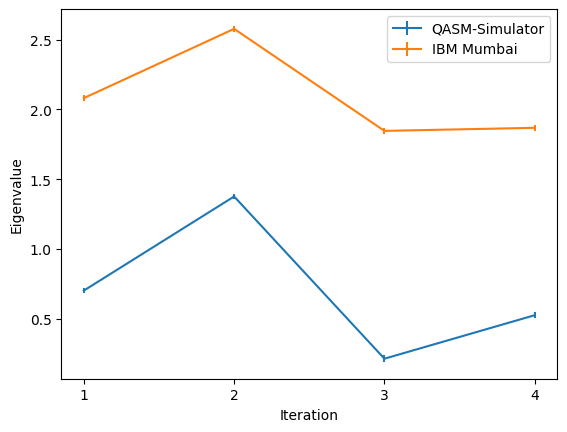

In [19]:
plt.errorbar(range(1,5),[store_quantum[i]['result'].eigenvalue for i in range(1,5)],
             yerr=[store_hardware[i]['job'].result().metadata[0]['variance']/store_hardware[i]['job'].result().metadata[0]['shots'] for i in range(1,5)],label='QASM-Simulator')
plt.errorbar(range(1,5),[store_hardware[i]['eig'] for i in range(1,5)],
             yerr=[store_hardware[i]['job'].result().metadata[0]['variance']/store_hardware[i]['job'].result().metadata[0]['shots'] for i in range(1,5)],label='IBM Mumbai')
plt.xlabel("Iteration")
plt.ylabel("Eigenvalue")
plt.xticks(range(1,5))
plt.legend()

## Benchmark

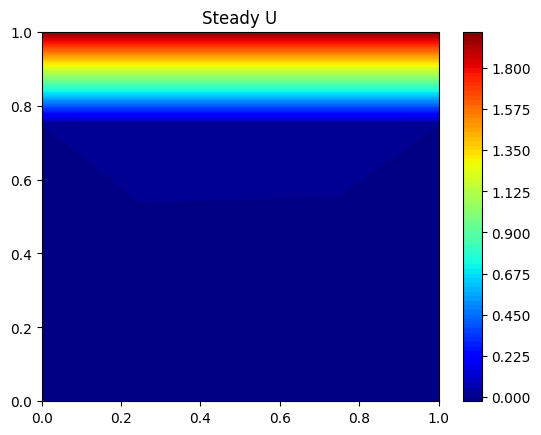

In [20]:
X, Y = np.meshgrid(x.toarray(), y.toarray())
plt.figure()
plt.contourf(X, Y, u.toarray().T, 80, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

In [21]:
GhiaU = np.loadtxt('./Benchmark/GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./Benchmark/GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [22]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./Benchmark/GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

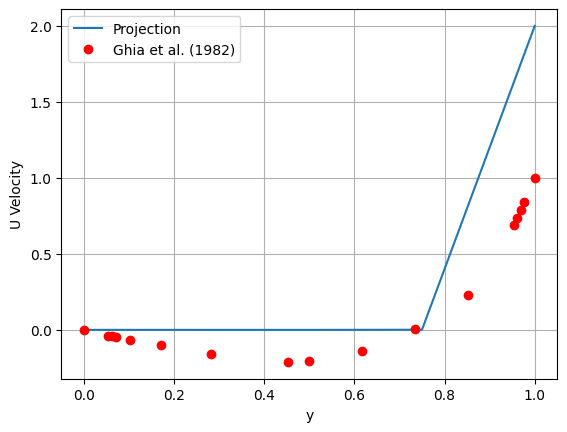

In [23]:
plt.plot(y.toarray(), u.toarray()[len(u.toarray())//2,:].T, label="Projection")
plt.plot(y_Ghia, GhiaU[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.legend()